# Exercise 2.1

In [1]:
%matplotlib inline

In [2]:
print('Pr = Pr(greedy|e>0.5) + Pr(greedy|e<0.5) =', 0.5 + 0.5*0.5)

import random
eps = 0.5
a1 = 0
a2 = 0
N = 100000
for i in range(N):
    if random.random() > 0.5: #select the greedy option
        a1 += 1
    else: # Select equally amongst all actions
        if random.random() > 0.5:
            a1 += 1
        else:
            a2 += 1

print('Pr(a1) = ', a1/N)
print('Pr(a2) = ', a2/N)

Pr = Pr(greedy|e>0.5) + Pr(greedy|e<0.5) = 0.75
Pr(a1) =  0.75266
Pr(a2) =  0.24734


# Exercise 2.2
Estimate of the true value (eqn 2.1):

$Q_t(a) = \frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_i = a}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_i = a}}$

Gready action selection:

$A_t = \text{argmax}_{a} Q_t(a)$

Epsilon gready selection:

$    A_t= 
\begin{cases}
    \textrm{argmax}_{a} Q_t(a),& \text{if } X \geq \epsilon\\
    \text{sample uniformly},              & \text{otherwise}
\end{cases}$

Given Q1(a)=0: A1=1 could have been $\epsilon$, was likely a greedy action. R1=-1

Given Q2(1)=-1: A2=2 likely a greed action, could have been $\epsilon$. R2=1

Given Q3(1)=-1, Q3(2)=1: A3=2 likley a greedy action, could have been $\epsilon$. R3=-2

Given Q4(1)=-1, Q4(2)=-1/2: A4=2 is definitely an $\epsilon$ action as A(3,4) is argmax Q. R4=2

Given Q5(1)=-1, Q5(2)=1/3: A5=3 us definitely an $\epsilon$ action as A(2) is argmax Q. R5=0

# Exercise 2.3

As $Q_t(a) \rightarrow q_*(a)$ as $t\rightarrow\infty$ we expect $P(a_*) \ge 1-\epsilon$.

Thus the lowest learning rate ($\epsilon$) will have the greatest probablity of selecting the optimal action in the limit.

$\epsilon=0.01 \implies P(a_*)\ge0.99$ in the limit I would expect $P(a_*)\rightarrow(1-\epsilon) + \epsilon*(1/k) = 0.991$

# Implementing Figure 2.2

100%|██████████| 2000/2000 [04:45<00:00,  7.00it/s]


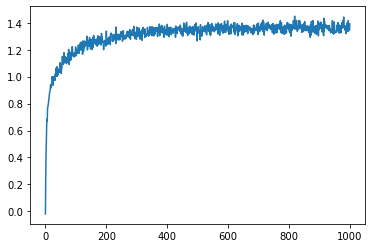

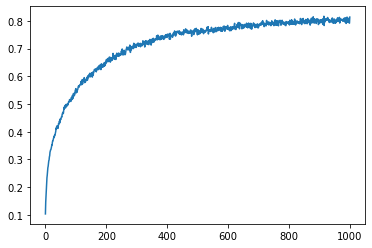

In [3]:

import random
import numpy
import matplotlib.pyplot as plt
import tqdm

class TenArmBandit():
    def __init__(self,epsilon=0.1,k=10):
        self.k = k
        self.Q = [0]*self.k
        self.R_history = [[] for i in range(self.k)] # avoid pointing to same list in memory
        self.R = []
        self.A = []
        self.epsilon = epsilon
        self.indexes = range(self.k)
        
        # Generate the means
        self.means = []
        for i in range(self.k):
            self.means.append(random.gauss(0,1))
            
        self.A_optimal = numpy.argmax(self.means)
    
    def get_reward(self, At):
        return random.gauss(self.means[At],1)
    
    def sample_action(self, ):
        if random.random() >= self.epsilon:
            a = numpy.amax(self.Q)
            if numpy.sum(numpy.argwhere(self.Q == a)) > 1:
                ind = numpy.argwhere(self.Q == a)
                At = random.choice(ind)[0]
            else:
                At = numpy.argmax(self.Q)
        else:
            At = random.randint(0, self.k-1)
        return At
    
    def log_history(self, At,Rt):
        self.A.append(At)
        self.R_history[At].append(Rt)
        self.R.append(Rt)
    
    def estimate_Q_value(self, ):
#         print(self.R_history)
        for i in range(len(self.R_history)):
            if len(self.R_history[i]) > 0:
                self.Q[i] = numpy.mean(self.R_history[i])
            else:
                self.Q[i] = 0
    
    def run(self, n=2000):
        for i in range(n):
            At = self.sample_action()
            Rt = self.get_reward(At)
            self.log_history(At,Rt)
            self.estimate_Q_value()
            
m = 2000
n = 1000
R = numpy.zeros((m,n))
A = numpy.zeros((m,n))
for i in tqdm.trange(m):
       
    a = TenArmBandit(epsilon=0.1)
    a.run(n)
    
    R[i,:] = a.R
    A[i,:] = a.A == a.A_optimal
    

R = numpy.mean(R,axis=0)
A = numpy.mean(A,axis=0)
    
plt.figure()
plt.plot(R)

plt.figure()
plt.plot(A)
plt.show()



100%|██████████| 2000/2000 [01:08<00:00, 29.19it/s]


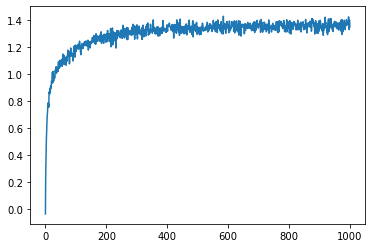

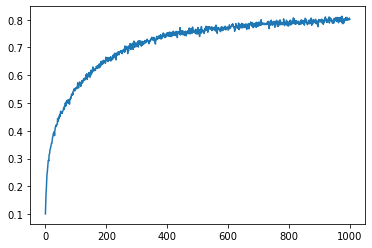

In [4]:

import random
import numpy
import matplotlib.pyplot as plt
import tqdm

class TenArmBandit():
    def __init__(self,epsilon=0.1,k=10):
        self.k = k
        self.Q = [0]*self.k
        self.N = [0]*self.k
        
        self.R = []
        self.A = []
        
        self.epsilon = epsilon
        
        # Generate the means
        self.means = []
        for i in range(self.k):
            self.means.append(random.gauss(0,1))
            
        self.A_optimal = numpy.argmax(self.means)
    
    def get_reward(self, At):
        return random.gauss(self.means[At],1)
    
    def sample_action(self, ):
        if random.random() >= self.epsilon:
            a = numpy.amax(self.Q)
            if numpy.sum(numpy.argwhere(self.Q == a)) > 1:
                ind = numpy.argwhere(self.Q == a)
                At = random.choice(ind)[0]
            else:
                At = numpy.argmax(self.Q)
        else:
            At = random.randint(0, self.k-1)
        return At
    
    def log_history(self, At, Rt):
        self.R.append(Rt)
        self.A.append(At)
    
    def run(self, n=2000):
        for i in range(n):
            At = self.sample_action()
#             print(At)
            Rt = self.get_reward(At)
            self.N[At] = self.N[At] + 1
            self.Q[At] = self.Q[At] + 1/self.N[At]*(Rt - self.Q[At])
            self.log_history(At,Rt)
            
m = 2000
n = 1000
R = numpy.zeros((m,n))
A = numpy.zeros((m,n))
for i in tqdm.trange(m):
       
    a = TenArmBandit(epsilon=0.1)
    a.run(n)
    
    R[i,:] = a.R
    A[i,:] = a.A == a.A_optimal
    

R = numpy.mean(R,axis=0)
A = numpy.mean(A,axis=0)
    
plt.figure()
plt.plot(R)

plt.figure()
plt.plot(A)
plt.show()


# Exercise 2.5

100%|██████████| 2000/2000 [16:46<00:00,  1.99it/s]


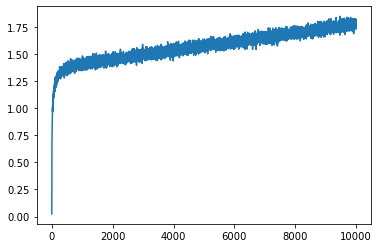

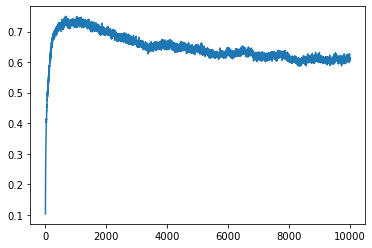

In [5]:

import random
import numpy
import matplotlib.pyplot as plt
import tqdm

class TenArmBandit():
    def __init__(self,epsilon=0.1,k=10):
        self.k = k
        self.Q = [0]*self.k
        self.N = [0]*self.k
        
        self.R = []
        self.A = []
        self.Aifstar = []
        
        self.epsilon = epsilon
        
        # Generate the means
        self.means = []
        for i in range(self.k):
            self.means.append(random.gauss(0,1))
            
        self.A_optimal = numpy.argmax(self.means)
    
    def walk(self):
        for i in range(self.k):
            self.means[i] = self.means[i] + random.gauss(0,0.01)
        self.A_optimal = numpy.argmax(self.means)
    
    def get_reward(self, At):
        return random.gauss(self.means[At],1)
    
    def sample_action(self, ):
        if random.random() >= self.epsilon:
            a = numpy.amax(self.Q)
            if numpy.sum(numpy.argwhere(self.Q == a)) > 1:
                ind = numpy.argwhere(self.Q == a)
                At = random.choice(ind)[0]
            else:
                At = numpy.argmax(self.Q)
        else:
            At = random.randint(0, self.k-1)
        return At
    
    def log_history(self, At, Rt):
        self.R.append(Rt)
        self.A.append(At)
        self.Aifstar.append(At == self.A_optimal)
    
    def run(self, n=2000):
        for i in range(n):
            self.walk()
            At = self.sample_action()
#             print(At)
            Rt = self.get_reward(At)
            self.N[At] = self.N[At] + 1
            self.Q[At] = self.Q[At] + 1/self.N[At]*(Rt - self.Q[At])
            self.log_history(At,Rt)
            
m = 2000
n = 10000
R = numpy.zeros((m,n))
A = numpy.zeros((m,n))
for i in tqdm.trange(m):
       
    a = TenArmBandit(epsilon=0.1)
    a.run(n)
    
    R[i,:] = a.R
    A[i,:] = a.Aifstar

R = numpy.mean(R,axis=0)
A = numpy.mean(A,axis=0)
    
plt.figure()
plt.plot(R)

plt.figure()
plt.plot(A)
plt.show()


100%|██████████| 2000/2000 [16:40<00:00,  2.00it/s]


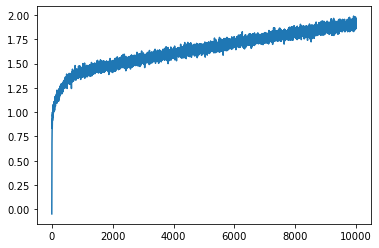

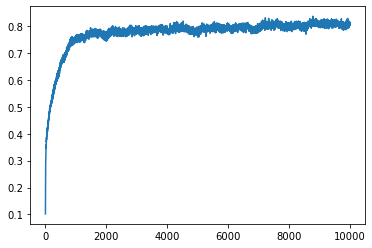

In [6]:

import random
import numpy
import matplotlib.pyplot as plt
import tqdm

class TenArmBandit():
    def __init__(self,epsilon=0.1,k=10):
        self.k = k
        self.Q = [0]*self.k
        self.N = [0]*self.k
        
        self.alpha = 0.1
        
        self.R = []
        self.A = []
        self.Aifstar = []
        
        self.epsilon = epsilon
        
        # Generate the means
        self.means = []
        for i in range(self.k):
            self.means.append(random.gauss(0,1))
            
           
    def walk(self):
        for i in range(self.k):
            self.means[i] = self.means[i] + random.gauss(0,0.01)
        self.A_optimal = numpy.argmax(self.means)
    
    def get_reward(self, At):
        return random.gauss(self.means[At],1)
    
    def sample_action(self, ):
        if random.random() >= self.epsilon:
            a = numpy.amax(self.Q)
            if numpy.sum(numpy.argwhere(self.Q == a)) > 1:
                ind = numpy.argwhere(self.Q == a)
                At = random.choice(ind)[0]
            else:
                At = numpy.argmax(self.Q)
        else:
            At = random.randint(0, self.k-1)
        return At
    
    def log_history(self, At, Rt):
        self.R.append(Rt)
        self.A.append(At)
        self.Aifstar.append(At == self.A_optimal)
    
    def run(self, n=2000):
        for i in range(n):
            self.walk()
            At = self.sample_action()
#             print(At)
            Rt = self.get_reward(At)
            self.N[At] = self.N[At] + 1
            self.Q[At] = self.Q[At] + self.alpha*(Rt - self.Q[At])
            self.log_history(At,Rt)
            
m = 2000
n = 10000
R = numpy.zeros((m,n))
A = numpy.zeros((m,n))
for i in tqdm.trange(m):
       
    a = TenArmBandit(epsilon=0.1)
    a.run(n)
    
    R[i,:] = a.R
    A[i,:] = a.Aifstar

R = numpy.mean(R,axis=0)
A = numpy.mean(A,axis=0)
    
plt.figure()
plt.plot(R)

plt.figure()
plt.plot(A)
plt.show()
